Enter image file path: /content/Screenshot 2024-08-30 112102.png


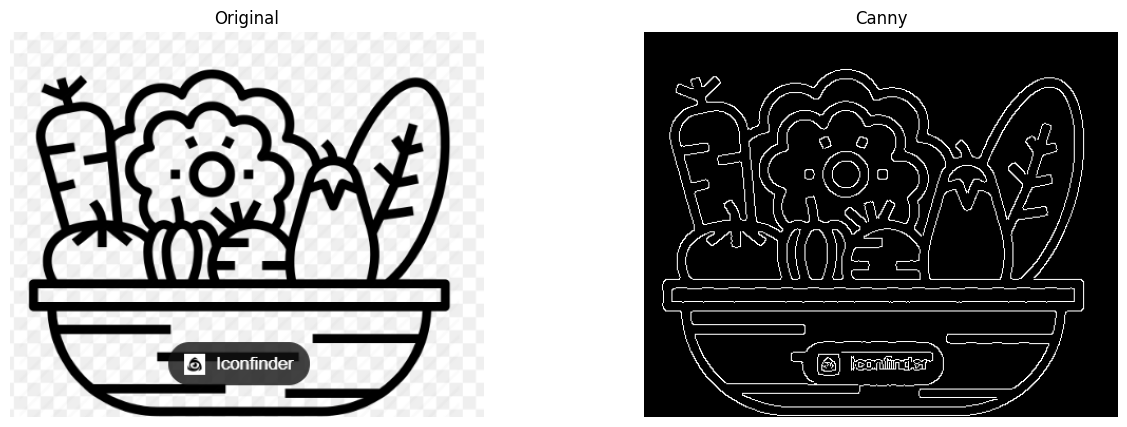

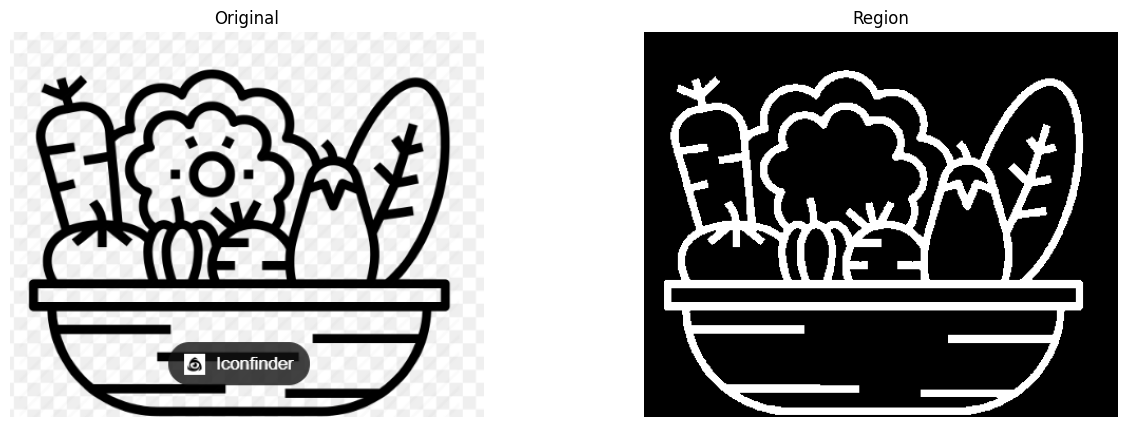

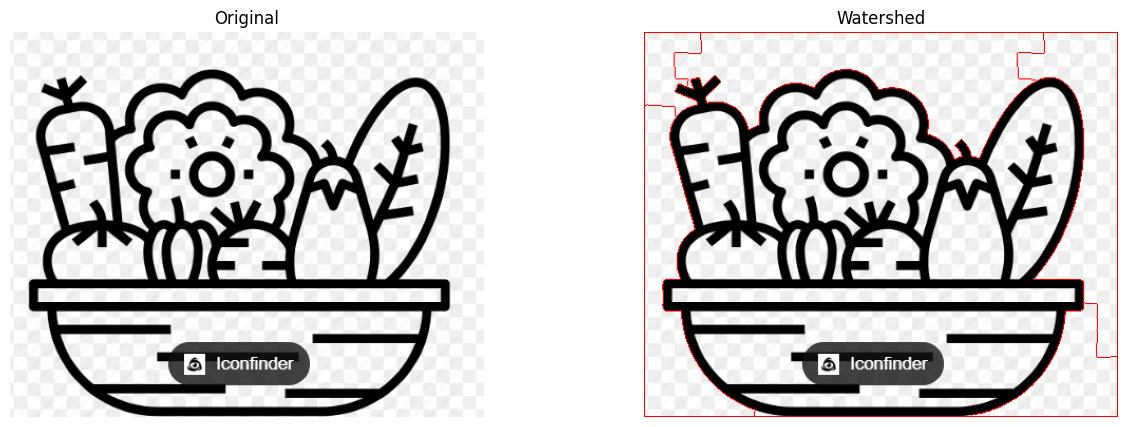

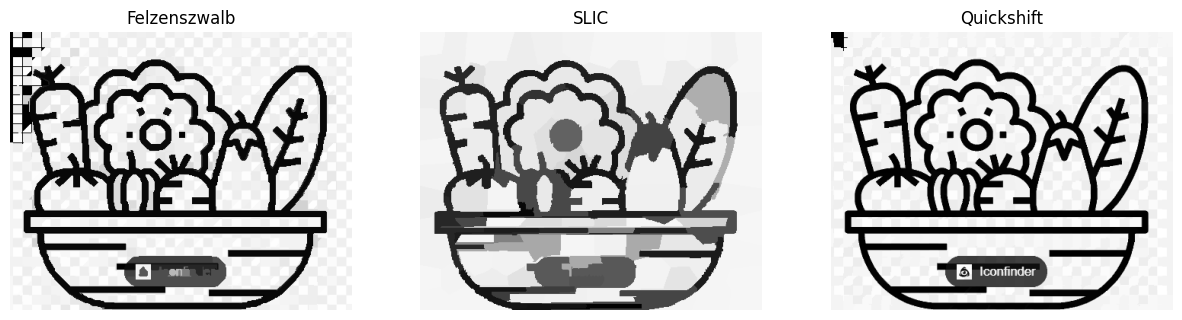

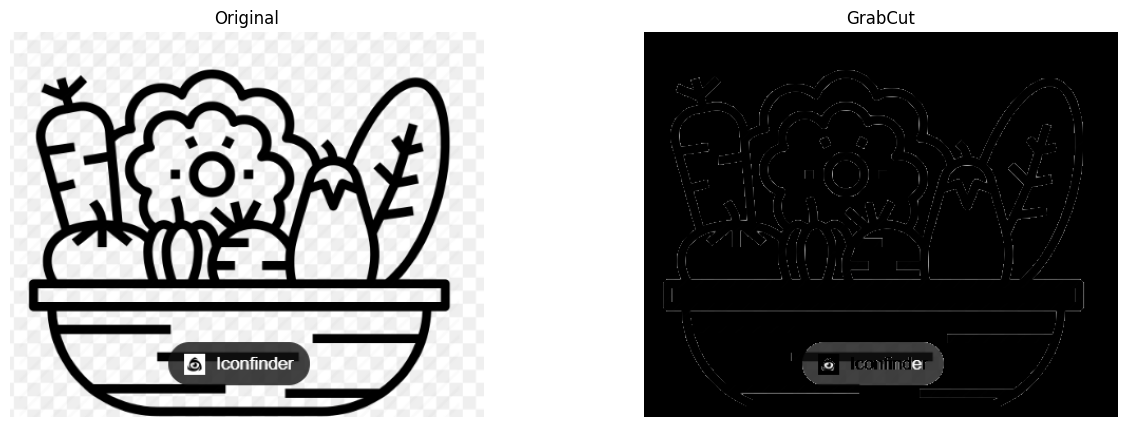

In [ ]:
# ==============================
# Image Segmentation Algorithms
# ==============================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color, img_as_float
from skimage.segmentation import felzenszwalb, slic, quickshift

# ------------------------------
# Helper: Show images side-by-side
# ------------------------------
def show(title, imgs):
    n = len(imgs)
    plt.figure(figsize=(15, 5))
    for i, (name, img) in enumerate(imgs.items()):
        plt.subplot(1, n, i+1)
        if len(img.shape) == 2:
            plt.imshow(img, cmap="gray")
        else:
            # Convert float images to uint8 for display
            if img.dtype == np.float64:
                img = (img * 255).astype(np.uint8)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(name)
        plt.axis("off")
    plt.show()

# ------------------------------
# 1. Edge-based Segmentation (Canny)
# ------------------------------
def edge_based(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 100, 200)
    return edges

# ------------------------------
# 2. Region Growing (simple seed-based)
# ------------------------------
def region_growing(img, seed=None, thresh=10):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    if seed is None:
        seed = (h//2, w//2)
    mask = np.zeros_like(gray, dtype=np.uint8)
    region_val = int(gray[seed])
    stack = [seed]
    while stack:
        x, y = stack.pop()
        if mask[x, y] == 0 and abs(int(gray[x, y]) - region_val) < thresh:
            mask[x, y] = 255
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
                    nx, ny = x+dx, y+dy
                    if 0 <= nx < h and 0 <= ny < w:
                        stack.append((nx, ny))
    return mask

# ------------------------------
# 3. Watershed Segmentation
# ------------------------------
def watershed_segmentation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, 0.7*dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown==255] = 0
    markers = cv2.watershed(img, markers)
    result = img.copy()
    result[markers == -1] = [0, 0, 255]
    return result

# ------------------------------
# 4. Mean-Shift / Felzenszwalb / SLIC (Superpixels)
# ------------------------------
def superpixel_segmentation(img):
    img_float = img_as_float(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    segments_fz = felzenszwalb(img_float, scale=100, sigma=0.5, min_size=50)
    segments_slic = slic(img_float, n_segments=200, compactness=10, sigma=1)
    segments_quick = quickshift(img_float, kernel_size=3, max_dist=6, ratio=0.5)

    out1 = color.label2rgb(segments_fz, img_float, kind='avg')
    out2 = color.label2rgb(segments_slic, img_float, kind='avg')
    out3 = color.label2rgb(segments_quick, img_float, kind='avg')

    return out1, out2, out3

# ------------------------------
# 5. GrabCut (Graph-cut)
# ------------------------------
def grabcut_segmentation(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    h, w = img.shape[:2]
    rect = (10, 10, w-20, h-20)  # rectangle around object
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    result = img * mask2[:, :, np.newaxis]
    return result

# ------------------------------
# Main Execution
# ------------------------------
if __name__ == "__main__":
    # Ask user for image
    path = input("Enter image file path: ")
    img = cv2.imread(path)
    if img is None:
        raise ValueError("Image not found. Check path.")

    # Apply methods
    edges = edge_based(img)
    region = region_growing(img)
    water = watershed_segmentation(img)
    sp1, sp2, sp3 = superpixel_segmentation(img)
    grab = grabcut_segmentation(img)

    # Show results
    show("Edge-based", {"Original": img, "Canny": edges})
    show("Region Growing", {"Original": img, "Region": region})
    show("Watershed", {"Original": img, "Watershed": water})
    show("Superpixels", {"Felzenszwalb": sp1, "SLIC": sp2, "Quickshift": sp3})
    show("GrabCut", {"Original": img, "GrabCut": grab})